# Part II - Factors that affect the outcome of a loan
## by Charles Nikoro

>**Before you start**: You must have the README.md file ready that include a summary of main findings that reflects on the steps taken during the data exploration (Part I notebook). The README.md file should also describes the key insights that will be conveyed by the explanatory slide deck (Part II  outcome)



## Investigation Overview

In this investigation, I wanted to explore the factors that could affect a loan's outcome. The main focus were on the principal outstanding, current number of days the borrower was delinquent, the employment status, and the term of the loan.


> Describe the overall goals of your presentation here. Add a summary of key insights at the start of the notebook, just as you added in the README.md. This will help your notebook to stay aligned to the key insights you want to include in your slide deck.

> **Rubric Tip**: The key insights in the slideshow must match those documented in the README.md summary. 


## Dataset Overview

The dataset comprises of approximately 114,000 records of loan applications from November 11, 2005 to March 3, 2014. Each record contains 81 features or variables.

I only considered loans that were either completed, defaulted, or charged-off. Apart from the main variable of interest, `LoanStatus`, others explored in this investigation are: `LoanOriginalAmount`, `LP_CustomerPrincipalPayments`,`BorrowerAPR`, `LP_InterestandFees`, `Term`, `LoanCurrentDaysDelinquent`, `EmploymentStatus`, `ListingCategory (numeric)`, and `TotalProsperLoans`.

`EmploymentStatus` variable comprises of "Not employed", "Full-time", "Part-time", "Retired", "Employed", "Self-employed", "Other", and "Not available" categories. For this investigation, I only considered records whose employment status are known. Therefore, records with an "Other" or "Not available" status where not considered. Furthermore, since it is safe to assume that borrowers with a "Full-time" and "Part-time" status have an employer, I merged them with those whose status is "Employed". Consequently, the categories of employment status considered are "Not employed", "Self-employed", "Employed", and "Retired".

After performing the above wrangling process, I was left with 46,688 records which was explored for this investigation.

> Provide a brief overview of the dataset to be presented here.

In [9]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import math

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
loans = pd.read_csv('../dataset/prosperLoanData.csv')

In [3]:
# merge records with Full-time and Part-time employment status with those with an Employed status
values_to_replace = ['Full-time', 'Part-time']
for value in values_to_replace:
    loans.EmploymentStatus.replace(value, "Employed", inplace=True)

# replacing missing Employment status records with "Not available"
loans.EmploymentStatus.fillna("Not available", inplace=True)

# exclude records with Other and Not available status
exclusion_list = ['Other', 'Not available']
loans = loans.query('EmploymentStatus not in @exclusion_list')

In [4]:
# We will only consider Completed, Defaulted, and Charged-off loans

excluded_list = ['Current', 'Cancelled', 'FinalPaymentInProgress',
 'Past Due (1-15 days)', 'Past Due (16-30 days)', 'Past Due (31-60 days)', 
'Past Due (61-90 days)', 'Past Due (91-120 days)', 'Past Due (>120 days)', ]

loan_sub_data = loans.query('LoanStatus not in @excluded_list').copy()

In [5]:
def create_category_type(categories, ordered=False):
    """
        Create category type from the list of categories

        Args:
           list: the list of categories
           bool: whether the category type should be ordered. This is False by default

        Returns:
           a pandas CategoricalDtype object.
    """
    return pd.api.types.CategoricalDtype(categories=categories, ordered=ordered)

# make ListingCategory (numeric), and Term of categorical types
loan_sub_data['ListingCategory (numeric)'] = loan_sub_data['ListingCategory (numeric)'].astype(
    create_category_type(range(21))
)

loan_sub_data.Term = loan_sub_data.Term.astype(create_category_type([12,36,60], ordered=True))

# EmploymentStatus should also be categorical
categories = ['Not employed', 'Self-employed', 'Employed', 'Retired']
loan_sub_data.EmploymentStatus = loan_sub_data.EmploymentStatus.astype(create_category_type(categories=categories))

# the loan status should be categorical. We will also make it ordinal
categories = ['Completed', 'Defaulted', 'Chargedoff']

loan_sub_data.LoanStatus = loan_sub_data.LoanStatus.astype(create_category_type(categories=categories, ordered=True))

# The shape of the subset of data we will be analyzing
print(loan_sub_data.shape)

(46688, 81)


In [6]:
# create the LoanPrincipalOutstanding variable and correct negative principal outstandings
loan_sub_data['LoanPrincipalOutstanding'] = loan_sub_data.LoanOriginalAmount - loan_sub_data.LP_CustomerPrincipalPayments

# add excess principal payments to LP_InterestandFees
negative_principal_outstanding = loan_sub_data[loan_sub_data.LoanPrincipalOutstanding<0]
additional_interest_and_fees = negative_principal_outstanding.LoanPrincipalOutstanding * -1

to_replace = negative_principal_outstanding.LP_InterestandFees.values
values = to_replace + additional_interest_and_fees.values
loan_sub_data.LP_InterestandFees.replace(to_replace, values, inplace=True)

# set LP_CustomerPrincipalPayments of these records to be the same as LoanOriginalAmount
to_replace = negative_principal_outstanding.LP_CustomerPrincipalPayments.values
values = negative_principal_outstanding.LoanOriginalAmount.values
loan_sub_data.LP_CustomerPrincipalPayments.replace(to_replace, values, inplace=True)

# replace negative principal outstanding with 0
to_replace = negative_principal_outstanding.LoanPrincipalOutstanding.values
loan_sub_data.LoanPrincipalOutstanding.replace(to_replace, 0, inplace=True)


> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Distribution of Loan Status

Most of the borrowers completed their loans as we can see from the count plot.

> Write a comment about your visualization here. The visualization should be in the next cell, as a sub-slide type. Make sure your visualizations are polished!

> **Rubric Tip**: Provide at least 3 **polished** visualizations to convey key insights. The total number of visualizations in the slideshow shoould be less than 50% of the number of visualizations in the exploratory analysis. For example, if the exploratory analysis (Part I) has 18 visualizations, the slideshow can have (3 - 8) visualizations. 


> **Rubric Tip**: Each visualization in the slideshow is associated with **descriptive comments** that accurately depict their purpose and your observation. 


> **Rubric Tip**: All plots in the slideshow are appropriate, meaning the plot type, encodings, and transformations are suitable to the underlying data. 

> **Rubric Tip**: All plots in the slideshow are polished, meaning all plots have a title, labeled x/y axes (with units), x/y ticks, and legends. 

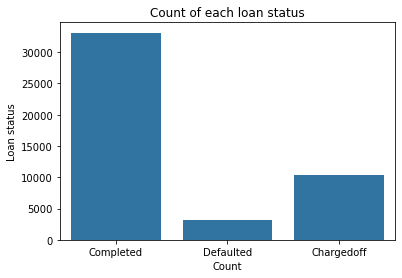

In [8]:
# Count plot of the Loan status

sns.countplot(data=loan_sub_data, x='LoanStatus', color=sns.color_palette()[0])
plt.xlabel('Count')
plt.ylabel('Loan status')
plt.title('Count of each loan status')
plt.show();

## Distribution of principal outstandings

The distribution is unimodal with most of the borrowers having no outstandings which collaborate with our observation that most of them completed their loans. The distribution is plotted with a log scale on the y-axis.

> You should have at least three visualizations in your presentation,
but feel free to add more if you'd like!

In [10]:
# function for computing optimal number of bins

def get_bin_counts(series):
    """
       computes number of bins needed to plot the histogram of series
       using Freedman Diaconis algorithm if the IQR is not 0 else
       take the square root of the number of data points rounded up
       to the nearest integer
       
       :param series: quantitative pandas series
       :return integer: the number of bins
    """
    if series.quantile(0.75) - series.quantile(0.25) != 0:
        bin_width = 2*((series.quantile(0.75)-series.quantile(0.25))/(np.power(series.shape[0],1/3)))
        return ((series.max()-series.min())//bin_width).astype(int)
    return int(math.ceil(math.sqrt(series.shape[0])))

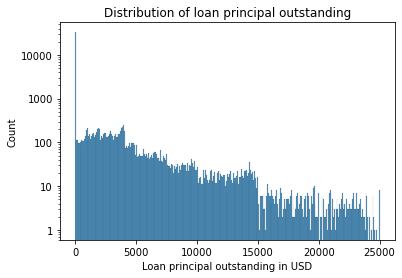

In [13]:
# distribution of the loan principal outstanding on a log scale along the y-axis

ax = sns.histplot(data=loan_sub_data, x='LoanPrincipalOutstanding',
            bins=get_bin_counts(loan_sub_data.LoanPrincipalOutstanding))
            
ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(ScalarFormatter())
ax.set_xlabel('Loan principal outstanding in USD')
ax.set_title('Distribution of loan principal outstanding')

plt.show();

## Distribution of number of days borrowers were delinquent

The distribution is also unimodal with a peak around 0 which shows that most borrowers were not delinquent on their payments. It was also plotted with a log scale on the y-axis.

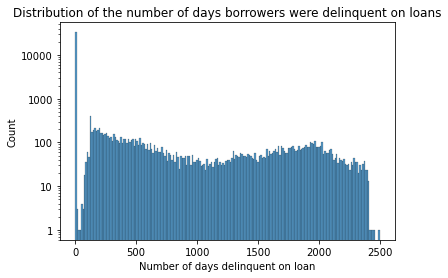

In [14]:
# distribution of LoanCurrentDaysDelinquent

ax = sns.histplot(data=loan_sub_data, x='LoanCurrentDaysDelinquent', 
                 bins=get_bin_counts(loan_sub_data.LoanCurrentDaysDelinquent))

ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(ScalarFormatter())

ax.set_xlabel('Number of days delinquent on loan')
ax.set_title('Distribution of the number of days borrowers were delinquent on loans')

plt.show();

## Relationship between loan status and principal outstanding

The box plot shows an increase in the median of the principal outstanding across the loan status with charged off loans having the largest median value.

In [ ]:
# box plot showing the relationship between loan status and principal outstanding

sns.boxplot(data=loan_sub_data, x='LoanStatus', y='LoanPrincipalOutstanding')

>**Generate Slideshow**: Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show. . From the terminal or command line, use the following expression.

In [ ]:
!jupyter nbconvert <Part_II_Filename>.ipynb --to slides --post serve --no-input --no-prompt

> This should open a tab in your web browser where you can scroll through your presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent slide. Make sure you remove all of the quote-formatted guide notes like this one before you finish your presentation! At last, you can stop the Kernel. 